In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'figure.dpi': 72, 'savefig.dpi': 1200,
})

import pickle
import numpy as np
import torch

rng = np.random.default_rng()

### Load distribution data from file

In [2]:
from torch.utils.data import TensorDataset, DataLoader, random_split

with open('dataset_beta.pickle', 'rb') as f:
    saved = pickle.load(f)

num_bins = saved['ps'].shape[1]
eps = 1e-4
dset = TensorDataset(
    torch.tensor(saved['ps']*(1-eps)+eps/num_bins, dtype=torch.float),
    torch.tensor(saved['params'], dtype=torch.float),
)
_N = len(dset)
dset_train, dset_val, dset_test = random_split(
    dset, [_N-2*int(_N*0.05), int(_N*0.05), int(_N*0.05)],
)

batch_size = 32
loader_train = DataLoader(dset_train, batch_size, shuffle=True, drop_last=True)
loader_val = DataLoader(dset_val, batch_size)
loader_test = DataLoader(dset_test, batch_size)

### Setup for auto-encoder training

In [3]:
from models import AutoEncoder
from torch.optim import SGD
from torch.nn import KLDivLoss

latent_dim = 2
num_features = [64, 16]
model = AutoEncoder(num_bins, latent_dim, num_features)

lr = 0.01
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

criterion = KLDivLoss(reduction='batchmean')

### Training denoising auto-encoder

Each training batch is augmented by sampling noise with `num_samples` controling the degree of noise.

In [4]:
from scipy.stats import multinomial
from torch.nn.functional import log_softmax

def augment(ps, num_samples=100):
    fs = []
    for i in range(len(ps)):
        fs.append(multinomial.rvs(num_samples, ps[i].data.cpu().numpy())/num_samples)
    fs = torch.tensor(np.stack(fs)).to(ps)
    return fs

def train(model, loader, criterion, optimizer, num_samples=100, device='cuda'):
    model.train().to(device)
    
    for ps, _ in loader:
        ps = ps.to(device)
        if ps.min()<1e-6:
            raise RuntimeError
        fs = augment(ps, num_samples)
        logits = model(fs)
        logps = log_softmax(logits, dim=1)
        
        loss = criterion(logps, ps)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def evaluate(model, loader, criterion, num_samples=100, device='cuda'):
    model.eval().to(device)
    
    loss = 0.
    for ps, _ in loader:
        ps = ps.to(device)
        fs = augment(ps, num_samples)
        with torch.no_grad():
            logits = model(fs)
            logps = log_softmax(logits, dim=1)
        
        loss += criterion(logps, ps).item()*len(ps)
    loss /= len(loader.dataset)
    return loss
        
num_samples = 100 # multinomial sampling noise
num_epochs = 50
best_loss, best_state, best_epoch = np.inf, None, None
for e_idx in range(1, num_epochs+1):
    verbose = e_idx%(num_epochs//10)==0
    if verbose:
        print(f"Epoch {e_idx}")
    train(model, loader_train, criterion, optimizer, num_samples)
    loss_val = evaluate(model, loader_val, criterion, num_samples)
    loss_test = evaluate(model, loader_test, criterion, num_samples)
    if loss_val<best_loss:
        best_loss = loss_val
        best_state = model.state_dict()
        best_epoch = e_idx
    if verbose:
        print('loss_val: {:.3f}, loss_test: {:.3f}'.format(loss_val, loss_test))

model.load_state_dict(best_state)
model.eval().cpu()
print(f"Best model at epoch {best_epoch} loaded")

Epoch 5
loss_val: 0.016, loss_test: 0.017
Epoch 10
loss_val: 0.011, loss_test: 0.011
Epoch 15
loss_val: 0.010, loss_test: 0.009
Epoch 20
loss_val: 0.010, loss_test: 0.010
Epoch 25
loss_val: 0.010, loss_test: 0.010
Epoch 30
loss_val: 0.009, loss_test: 0.009
Epoch 35
loss_val: 0.009, loss_test: 0.010
Epoch 40
loss_val: 0.009, loss_test: 0.010
Epoch 45
loss_val: 0.009, loss_test: 0.009
Epoch 50
loss_val: 0.011, loss_test: 0.010
Best model at epoch 39 loaded


### Auto-encoder on testing set

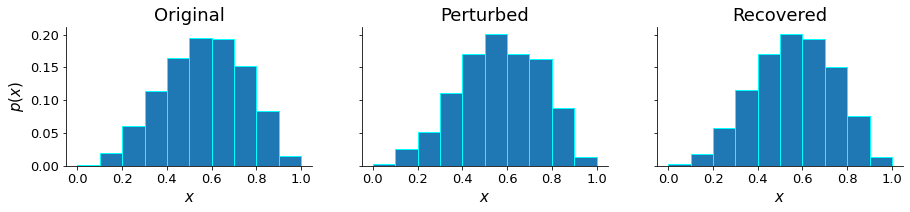

In [5]:
from torch.nn.functional import softmax

ps, _ = next(iter(loader_test))
fs = augment(ps, 1000)
with torch.no_grad():
    logits = model(fs)
    ys = softmax(logits, dim=1)
    
xs = saved['xs']
idx = rng.choice(len(ps))
_, axes = plt.subplots(1, 3, figsize=(15, 2.5), sharey=True)
for i, ax in enumerate(axes):
    if i==0:
        height = ps[idx]
        title = 'Original'
    if i==1:
        height = fs[idx]
        title = 'Perturbed'
    if i==2:
        height = ys[idx]
        title = 'Recovered'
    ax.bar(xs, height, width=1/num_bins, edgecolor='cyan')
    ax.set_xlabel(r'$x$')
    ax.set_title(title)
axes[0].set_ylabel(r'$p(x)$')
plt.show()

### Examine latent space

In [6]:
zs, cs = [], []
for ps, params in loader_test:
    with torch.no_grad():
        zs.append(model.encoder(ps))
    cs.append((params-2)/8) # beta parameters in [2, 10]
zs = torch.cat(zs)
cs = torch.cat(cs)
# R-channel and B-channel for (a, b) in beta distribution
cs = torch.stack([cs[:, 0], torch.ones(size=(len(zs),))*0.5, cs[:, 1]], dim=1)

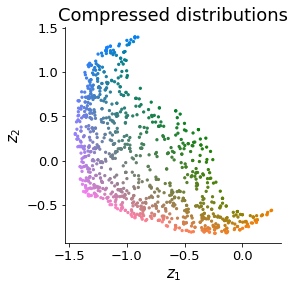

In [7]:
idxs = rng.choice(len(zs), size=min(len(zs), 1000))

if latent_dim==2:
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.scatter(zs[idxs, 0], zs[idxs, 1], s=5, c=cs[idxs])
    ax.set_xlabel(r'$z_1$')
    ax.set_ylabel(r'$z_2$')
if latent_dim==3:
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.scatter(zs[idxs, 0], zs[idxs, 1], zs[idxs, 2], s=5, c=cs[idxs])
    ax.set_xlabel(r'$z_1$')
    ax.set_ylabel(r'$z_2$')
    ax.set_zlabel(r'$z_3$')
    ax.view_init(15, 30)
ax.set_title('Compressed distributions')
plt.show()